#### Smart Home Data [source](https://www.kaggle.com/code/offmann/smart-home-dataset/input)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data/HomeC.csv")
df.head()

C:\Users\phuro\AppData\Local\Temp\ipykernel_26656\2645709189.py:1: DtypeWarning: Columns (0,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/HomeC.csv")


,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],...,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
0,1451624400,0.932833,0.003483,0.932833,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
1,1451624401,0.934333,0.003467,0.934333,0.000000,0.020717,0.063817,0.444067,0.124000,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
2,1451624402,0.931817,0.003467,0.931817,0.000017,0.020700,0.062317,0.446067,0.123533,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
3,1451624403,1.022050,0.003483,1.022050,0.000017,0.106900,0.068517,0.446583,0.123133,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
4,1451624404,1.139400,0.003467,1.139400,0.000133,0.236933,0.063983,0.446533,0.122850,0.006850,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0


In [3]:
df.isna().sum().sort_values(ascending=False).head(1)

Microwave [kW]    1
dtype: int64

In [4]:
df.shape

(503911, 32)

In [5]:
df.columns

Index(['time', 'use [kW]', 'gen [kW]', 'House overall [kW]', 'Dishwasher [kW]',
       'Furnace 1 [kW]', 'Furnace 2 [kW]', 'Home office [kW]', 'Fridge [kW]',
       'Wine cellar [kW]', 'Garage door [kW]', 'Kitchen 12 [kW]',
       'Kitchen 14 [kW]', 'Kitchen 38 [kW]', 'Barn [kW]', 'Well [kW]',
       'Microwave [kW]', 'Living room [kW]', 'Solar [kW]', 'temperature',
       'icon', 'humidity', 'visibility', 'summary', 'apparentTemperature',
       'pressure', 'windSpeed', 'cloudCover', 'windBearing', 'precipIntensity',
       'dewPoint', 'precipProbability'],
      dtype='object')

#### Data preprocessing

In [6]:
# Rename columns to remove spaces and the kW unit 
df.columns = [col[:-5].replace(' ','_') if 'kW' in col else col for col in df.columns]

# Drop rows with nan values 
df = df.dropna()

# The columns "use" and "house_overall" are the same, so let's remove the 'house_overall' column
df.drop(['House_overall'], axis=1, inplace=True)

# The columns "gen" and "solar" are the same, so let's remove the 'solar' column
df.drop(['Solar'], axis=1, inplace=True)

# drop rows with cloudCover column values that are not numeric (bug in sensors) and convert column to numeric
df = df[df['cloudCover']!='cloudCover']
df["cloudCover"] = pd.to_numeric(df["cloudCover"])

# Create columns that regroup kitchens and furnaces 
df['kitchen'] = df['Kitchen_12'] + df['Kitchen_14'] + df['Kitchen_38']
df['Furnace'] = df['Furnace_1'] + df['Furnace_2']

# Convert "time" column (which is a unix timestamp) to a Y-m-d H-M-S 
import time 
start_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(int(df['time'].iloc[0])))
time_index = pd.date_range(start_time, periods=len(df), freq='min')  
time_index = pd.DatetimeIndex(time_index)
df = df.set_index(time_index)
df = df.drop(['time'], axis=1)

In [7]:
# Helpful functions

# lower first letter of a string  
func = lambda s: s[:1].lower() + s[1:] if s else ''

# Remove rows with values that appear less than a certain percentage %
def remove_less_percent(col, percent):
    keys_to_conserve = [key for key,value in df[col].value_counts(normalize=True).items() if value>=percent]
    return df[df[col].isin(keys_to_conserve)]


In [8]:
cols = list(df.dtypes.keys())
categ_cols = [col for col in cols if df[col].dtype=='O']
num_cols = [col for col in cols if col not in categ_cols]
print('categ_cols : ', categ_cols)
print('num_cols : ', num_cols)

categ_cols :  ['icon', 'summary']
num_cols :  ['use', 'gen', 'Dishwasher', 'Furnace_1', 'Furnace_2', 'Home_office', 'Fridge', 'Wine_cellar', 'Garage_door', 'Kitchen_12', 'Kitchen_14', 'Kitchen_38', 'Barn', 'Well', 'Microwave', 'Living_room', 'temperature', 'humidity', 'visibility', 'apparentTemperature', 'pressure', 'windSpeed', 'cloudCover', 'windBearing', 'precipIntensity', 'dewPoint', 'precipProbability', 'kitchen', 'Furnace']


In [9]:
print(len(df))
df = remove_less_percent('summary', 0.05)
print(len(df))
df = remove_less_percent('icon', 0.05)
print(len(df))

503852
466308
466308


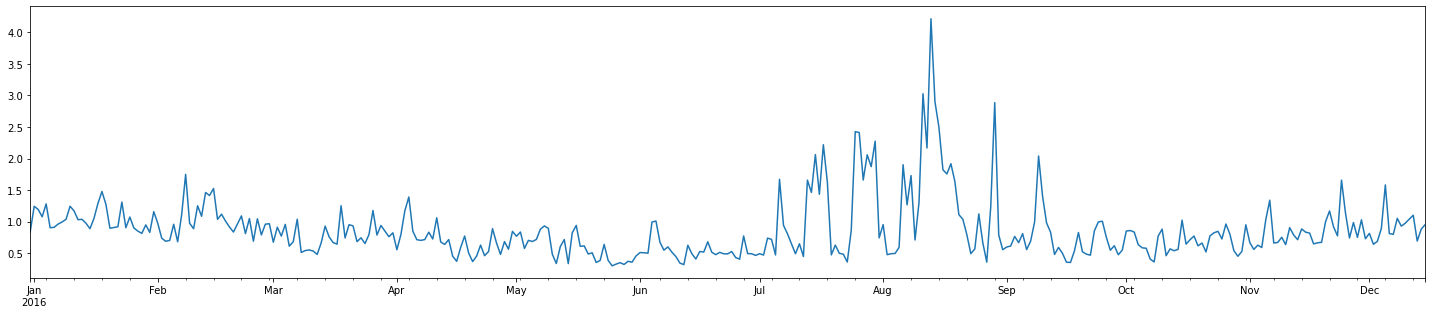

In [10]:
# plot use intensity by month, rolling monthly average

df['use'].resample(rule='D').mean().plot(figsize=(25,5));

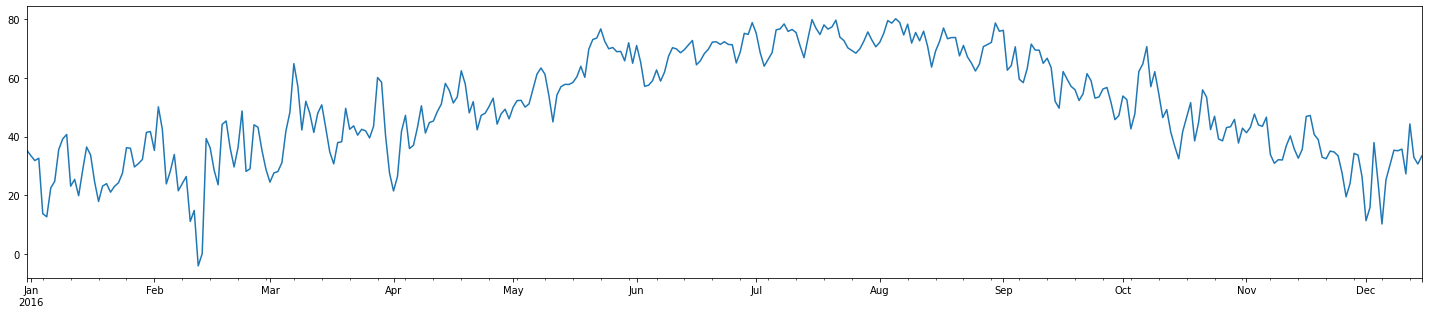

In [11]:
# plot temperature by month, rolling monthly average

df['temperature'].resample(rule='D').mean().plot(figsize=(25,5));

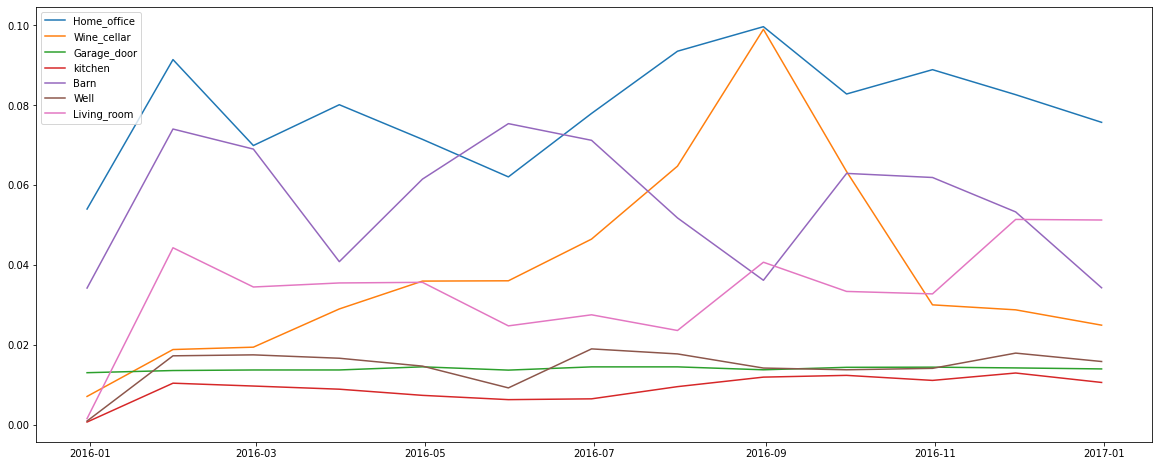

In [12]:
# plot room energy by month, rolling monthly average

rooms_energy_cols = ['Home_office', 'Wine_cellar','Garage_door',
                       'kitchen', 'Barn', 'Well','Living_room']

rooms_energy_per_month = df[rooms_energy_cols].resample('M').mean()   

plt.figure(figsize=(20,8))

sns.lineplot(data=rooms_energy_per_month, dashes=False);

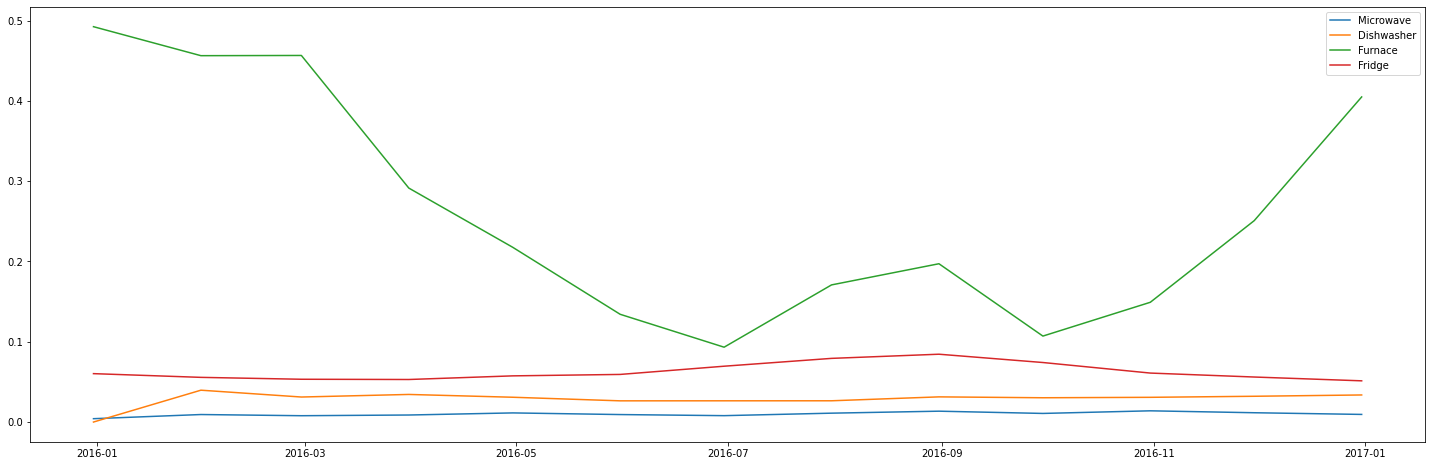

In [13]:
# plot equipment energy use by month, rolling monthly average

equipments_cols = ['Microwave', 'Dishwasher', 'Furnace', 'Fridge'] 

equipments_energy_per_month = df[equipments_cols].resample('M').mean()   

plt.figure(figsize=(25,8))

sns.lineplot(data= equipments_energy_per_month, dashes=False);

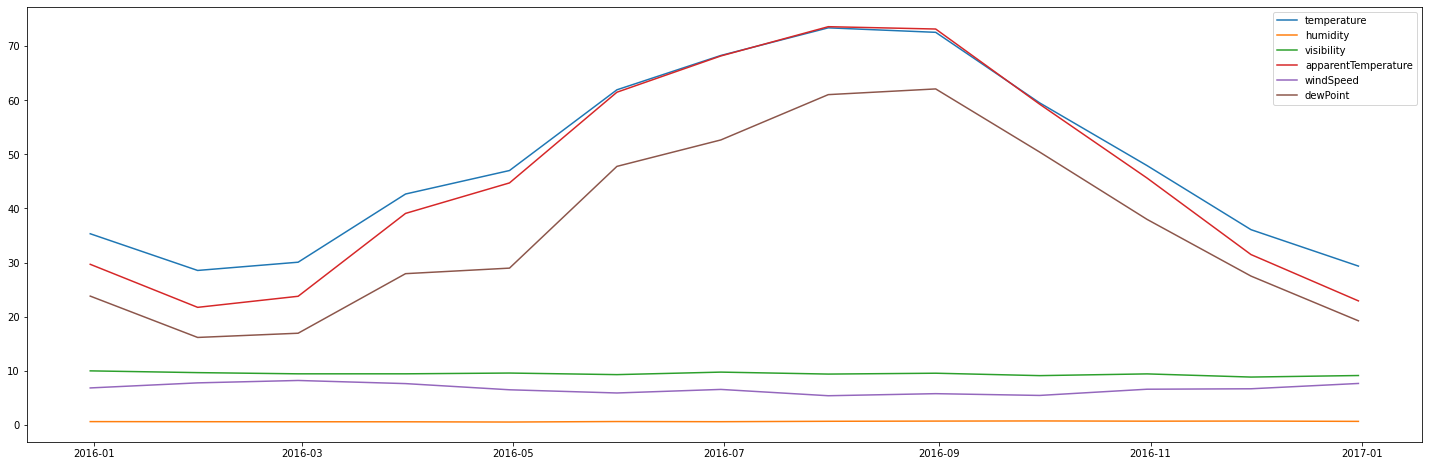

In [ ]:
# plot weather by month, rolling monthly average

weather_columns = ['temperature','humidity', 'visibility', 'apparentTemperature', 
                   'windSpeed', 'dewPoint']

weather_per_month = df[weather_columns].resample('M').mean()   

plt.figure(figsize=(25,8))

sns.lineplot(data=weather_per_month, dashes=False); 

#### Problem:  

1. Change Detection : Detecting excessive energy consumption in advance and preventing increase in usage fees.

1. Utility Bill Explanation : Segment systems using energy to identify source(s) of bill increases and pain points.

1. <i>(unpreferred but is an option)</i> Predict Future Consumption : Predicting future energy consumption and generation by utilizing weather information and optimizing energy supply.

#### Testing ways to let LLM read and understand tabular data

In [15]:
print(df.resample(rule='M').mean().to_string())

                 use       gen  Dishwasher  Furnace_1  Furnace_2  Home_office    Fridge  Wine_cellar  Garage_door  Kitchen_12  Kitchen_14  Kitchen_38      Barn      Well  Microwave  Living_room  temperature  humidity  visibility  apparentTemperature     pressure  windSpeed  cloudCover  windBearing  precipIntensity   dewPoint  precipProbability   kitchen   Furnace
2015-12-31  0.836898  0.003448    0.000091   0.238546   0.253805     0.054039  0.060343     0.007168     0.013105    0.000596    0.000156    0.000014  0.034275  0.001016   0.004256     0.001633    35.333115  0.625738   10.000000            29.688033  1016.016885   6.847049    0.750000   272.606557         0.000000  23.812787           0.000000  0.000765  0.492352
2016-01-31  1.047812  0.059034    0.039739   0.221878   0.234376     0.091420  0.055713     0.018900     0.013647    0.002872    0.007600    0.000010  0.074052  0.017327   0.009432     0.044356    28.553342  0.607230    9.675395            21.736173  1015.090114   7.7

In [16]:
df.columns

Index(['use', 'gen', 'Dishwasher', 'Furnace_1', 'Furnace_2', 'Home_office',
       'Fridge', 'Wine_cellar', 'Garage_door', 'Kitchen_12', 'Kitchen_14',
       'Kitchen_38', 'Barn', 'Well', 'Microwave', 'Living_room', 'temperature',
       'icon', 'humidity', 'visibility', 'summary', 'apparentTemperature',
       'pressure', 'windSpeed', 'cloudCover', 'windBearing', 'precipIntensity',
       'dewPoint', 'precipProbability', 'kitchen', 'Furnace'],
      dtype='object')

In [17]:
# separate columns related to energy consumption

use = df[[col for col in df.columns if col not in weather_columns+[
    'cloudCover', 'precipIntensity', 'precipProbability', 'windBearing', 'icon', 
    'summary', 'pressure']]]

use_str = use.resample(rule='M').mean().to_string()

print(use_str)

                 use       gen  Dishwasher  Furnace_1  Furnace_2  Home_office    Fridge  Wine_cellar  Garage_door  Kitchen_12  Kitchen_14  Kitchen_38      Barn      Well  Microwave  Living_room   kitchen   Furnace
2015-12-31  0.836898  0.003448    0.000091   0.238546   0.253805     0.054039  0.060343     0.007168     0.013105    0.000596    0.000156    0.000014  0.034275  0.001016   0.004256     0.001633  0.000765  0.492352
2016-01-31  1.047812  0.059034    0.039739   0.221878   0.234376     0.091420  0.055713     0.018900     0.013647    0.002872    0.007600    0.000010  0.074052  0.017327   0.009432     0.044356  0.010482  0.456255
2016-02-29  0.995173  0.058891    0.031232   0.222302   0.234220     0.069926  0.053357     0.019491     0.013786    0.002907    0.006851    0.000011  0.069036  0.017568   0.007959     0.034542  0.009769  0.456522
2016-03-31  0.770586  0.083415    0.034448   0.118393   0.173024     0.080134  0.053053     0.029050     0.013790    0.000656    0.008312    0.0

In [18]:
# prepare a sample

sample_data = use.head(10).to_csv(index=False)
print(sample_data)

use,gen,Dishwasher,Furnace_1,Furnace_2,Home_office,Fridge,Wine_cellar,Garage_door,Kitchen_12,Kitchen_14,Kitchen_38,Barn,Well,Microwave,Living_room,kitchen,Furnace
0.6316,0.003466667,3.33e-05,0.158883333,0.0639,0.0434,0.0825,0.009083333,0.012983333,0.000516667,5e-05,0.0,0.031766667,0.001033333,0.004083333,0.001616667,0.000566667,0.22278333299999997
1.070016667,0.0035,0.000233333,0.497633333,0.0629,0.043583333,0.170883333,0.008883333,0.0125,0.00035,0.000216667,1.67e-05,0.0317,0.001083333,0.004083333,0.001683333,0.000583367,0.560533333
1.01625,0.003466667,0.000216667,0.466683333,0.062766667,0.043533333,0.14955,0.0089,0.012566667,0.000416667,0.0002,1.67e-05,0.031733333,0.001016667,0.004083333,0.001683333,0.000633367,0.52945
0.820666667,0.003466667,0.000216667,0.44695,0.062916667,0.043583333,0.0105,0.007733333,0.012616667,0.000733333,0.000333333,1.67e-05,0.031766667,0.001016667,0.0041,0.0016,0.0010833659999999999,0.509866667
0.539166667,0.003516667,3.33e-05,0.100133333,0.116283333,0.0433666

In [19]:
# combine the details

data_description = f"""
The dataset contains the following columns:
{', '.join(use.columns)}

Column description (everything in kilowatt):
"use" contains total energy consumption
"gen" contains total energy generated by means of solar or other power generation resources
The rest of the columns either contain energy consumed by a specific appliance or room in the house

Summary usage by month:
{use_str}

Sample data:
{sample_data}
"""

In [20]:
print(data_description)


The dataset contains the following columns:
use, gen, Dishwasher, Furnace_1, Furnace_2, Home_office, Fridge, Wine_cellar, Garage_door, Kitchen_12, Kitchen_14, Kitchen_38, Barn, Well, Microwave, Living_room, kitchen, Furnace

Column description (everything in kilowatt):
"use" contains total energy consumption
"gen" contains total energy generated by means of solar or other power generation resources
The rest of the columns either contain energy consumed by a specific appliance or room in the house

Summary usage by month:
                 use       gen  Dishwasher  Furnace_1  Furnace_2  Home_office    Fridge  Wine_cellar  Garage_door  Kitchen_12  Kitchen_14  Kitchen_38      Barn      Well  Microwave  Living_room   kitchen   Furnace
2015-12-31  0.836898  0.003448    0.000091   0.238546   0.253805     0.054039  0.060343     0.007168     0.013105    0.000596    0.000156    0.000014  0.034275  0.001016   0.004256     0.001633  0.000765  0.492352
2016-01-31  1.047812  0.059034    0.039739  

In [21]:
!pip install openai python-dotenv -q

In [22]:
import openai 
from dotenv import load_dotenv
import os 

load_dotenv()

GPT_MODEL = 'gpt-4o'

In [23]:
# API Configuration
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
openai.api_key = os.getenv("OPENAI_API_KEY")

In [24]:
# prepare prompt

prompt = f"""
This is a time-series dataset of utility usage for a smart home:
{data_description}

Please answer the following questions:
1. Identify any sources with an increasing trend in electricity usage over time.
2. Highlight any significant outliers or anomalies.
"""

In [25]:
# prepare 

messages = [
        {"role": "system", "content": "You are a smart home utility data analyst."},
        {"role": "user", "content": prompt},
    ]

response = openai.chat.completions.create(
    model=GPT_MODEL, messages=messages#, temperature=0.8
    )

In [27]:
print(response.choices[0].message.content)

To address your questions, let's analyze the data for trends and outliers.

### 1. Identify any sources with an increasing trend in electricity usage over time.

To determine which sources show an increasing trend in electricity usage, we can look for an upward trend in monthly energy consumption values over time:

- **Home_office**: Starting from December 2015 with 0.054039 kWh, the consumption increases and peaks at 0.099653 kWh in August 2016, indicating an upward trend.
- **Wine_cellar**: Shows a noticeable increase from 0.007168 kWh in December 2015 to 0.09899 kWh in August 2016, suggesting a strong increasing trend.
- **Fridge**: There's a slight upward drift from 0.060343 kWh in December 2015 to a peak of 0.084534 kWh in August 2016.

These trends reflect situations where energy consumption is growing consistently over the given timeframe.

### 2. Highlight any significant outliers or anomalies.

To identify significant outliers, we need to look for values that deviate significa

In [32]:
use.resample(rule='M').mean().iloc[0].sort_values(ascending=False)

use            0.836898
Furnace        0.492352
Furnace_2      0.253805
Furnace_1      0.238546
Fridge         0.060343
Home_office    0.054039
Barn           0.034275
Garage_door    0.013105
Wine_cellar    0.007168
Microwave      0.004256
gen            0.003448
Living_room    0.001633
Well           0.001016
kitchen        0.000765
Kitchen_12     0.000596
Kitchen_14     0.000156
Dishwasher     0.000091
Kitchen_38     0.000014
Name: 2015-12-31 00:00:00, dtype: float64